### This notebook requires the modified version of dask-glm with the [PR #89](https://github.com/dask/dask-glm/pull/89)

```
0. pip install git+https://github.com/dask/dask
1. git clone https://github.com/daxiongshu/dask-glm
2. cd dask-glm
3. git checkout allow_lbfgs_with_cupy
4. pip install -e .
```

In [ ]:
import os
GPU_id = '0,1,2,3'
os.environ['CUDA_VISIBLE_DEVICES'] = GPU_id
#os.environ["CUPY_EXPERIMENTAL_SLICE_COPY"] = "1"
num_gpus = len(GPU_id.split(','))

In [2]:
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
Path.ls = lambda x: list(x.iterdir())

import time
from tqdm import tqdm
import numpy as np

import cudf as gd
import cupy as cp
import subprocess

import dask
import dask_cudf
import dask.array as da
from dask import delayed,compute,persist

from dask_glm.estimators import LogisticRegression
from dask_glm.datasets import make_classification as make_classification
from dask_glm.datasets import make_regression
import dask_glm.algorithms

from dask_glm.families import Logistic
from dask_glm.regularizers import Regularizer


from dask.distributed import Client, wait
from dask_cuda import LocalCUDACluster


print('cudf',gd.__version__)
print('dask_cudf',dask_cudf.__version__)
print('dask',dask.__version__)
print('cupy',cp.__version__)

cudf 0.16.0
dask_cudf 0.16.0
dask 2.30.0+46.ge4bdfcf5
cupy 8.0.0


In [3]:
cmd = "hostname --all-ip-addresses"
process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
output, error = process.communicate()
IPADDR = str(output.decode()).split()[0]

cluster = LocalCUDACluster(ip=IPADDR)
client = Client(cluster)
client

Client Scheduler: tcp://10.33.227.161:45923 Dashboard: http://10.33.227.161:8787/status,Cluster Workers: 4 Cores: 4 Memory: 1.08 TB


### helper functions

In [4]:
def to_cupy(X, y):
    X = X.map_blocks(lambda x: cp.asarray(x),
                         dtype=X.dtype, meta=cp.asarray(X._meta))
    y = y.map_blocks(lambda x: cp.asarray(x),
                     dtype=y.dtype, meta=cp.asarray(y._meta))
    return X,y

### Dask GLM with cupy based dask array toy data

In [5]:
N = 200000
p = 100
chunks = 4
dx, dy = make_classification(n_samples=N, n_features=p, n_informative=10, chunksize=N//chunks)
dx, dy = to_cupy(dx, dy)

In [6]:
print(dx.shape,dy.shape)
print(type(dx),type(dy))

(200000, 100) (200000,)
<class 'dask.array.core.Array'> <class 'dask.array.core.Array'>


In [7]:
dx, dy = persist(dx, dy)
dx.compute_chunk_sizes()

dask.array<lambda, shape=(200000, 100), dtype=float64, chunksize=(50000, 100), chunktype=cupy.ndarray>

In [8]:
%%time
lr = LogisticRegression(solver='admm', max_iter=5)
lr.fit(dx,dy)
yp = lr.predict(dx)
print("accuracy",da.mean(yp==dy).compute())

accuracy 0.79057
CPU times: user 369 ms, sys: 68 ms, total: 437 ms
Wall time: 1.27 s


In [9]:
%%time
solvers = ['admm', 'lbfgs', 'newton', 'proximal_grad', 'gradient_descent']
for s in solvers:
    lr = LogisticRegression(solver=s, max_iter=5)
    lr.fit(dx,dy)
    yp = lr.predict(dx)
    print(s,"accuracy",da.mean(yp==dy).compute())

admm accuracy 0.79057
lbfgs accuracy 0.790785
newton accuracy 0.79045
proximal_grad accuracy 0.78905
gradient_descent accuracy 0.790505
CPU times: user 4.68 s, sys: 438 ms, total: 5.12 s
Wall time: 6.91 s


### Speedup Test

In [10]:
def get_run_time(solver,min_samples,max_samples,data_type='cupy'):
    times = []
    for n in range(min_samples,max_samples+1):
        n_samples=10**n
        n_features = 20
        chunks = 4
        dx, dy = make_classification(n_samples=n_samples, n_features=n_features, n_informative=10, chunksize=n_samples//chunks)
        if data_type=='cupy':
            dx, dy = to_cupy(dx, dy)
        dx, dy = persist(dx, dy)
        wait(dx)
        wait(dy)
        start = time.time()
        lr = LogisticRegression(solver=solver, max_iter=2)
        lr.fit(dx,dy)
        duration = time.time()-start
        del dx,dy
        del lr
        times.append(duration)
        print('%s samples:10^%d time:%.2f'%(solver,n,duration))
    return times

In [11]:
%%time
solvers = ['admm', 'lbfgs', 'newton', 'proximal_grad', 'gradient_descent']
cupy_time = {}
for s in solvers:
    cupy_time[s] = get_run_time(s,3,8,data_type='cupy')

admm samples:10^3 time:0.22
admm samples:10^4 time:0.21
admm samples:10^5 time:0.21
admm samples:10^6 time:0.22
admm samples:10^7 time:0.60
admm samples:10^8 time:6.16
lbfgs samples:10^3 time:0.41
lbfgs samples:10^4 time:0.57
lbfgs samples:10^5 time:0.44
lbfgs samples:10^6 time:0.45
lbfgs samples:10^7 time:0.93
lbfgs samples:10^8 time:6.46
newton samples:10^3 time:0.36
newton samples:10^4 time:0.40
newton samples:10^5 time:0.38
newton samples:10^6 time:0.54
newton samples:10^7 time:0.71
newton samples:10^8 time:6.06
proximal_grad samples:10^3 time:0.75
proximal_grad samples:10^4 time:0.90
proximal_grad samples:10^5 time:1.04
proximal_grad samples:10^6 time:1.19
proximal_grad samples:10^7 time:2.46
proximal_grad samples:10^8 time:17.61
gradient_descent samples:10^3 time:0.77
gradient_descent samples:10^4 time:0.85
gradient_descent samples:10^5 time:1.12
gradient_descent samples:10^6 time:0.95
gradient_descent samples:10^7 time:1.89
gradient_descent samples:10^8 time:15.21
CPU times: use

In [12]:
%%time

client = Client()
solvers = ['admm', 'lbfgs', 'newton', 'proximal_grad', 'gradient_descent']
numpy_time = {}
for s in solvers:
    numpy_time[s] = get_run_time(s,3,8,data_type='numpy')

admm samples:10^3 time:0.89
admm samples:10^4 time:0.53
admm samples:10^5 time:0.75
admm samples:10^6 time:4.73
admm samples:10^7 time:21.33
admm samples:10^8 time:112.82
lbfgs samples:10^3 time:0.41
lbfgs samples:10^4 time:0.96
lbfgs samples:10^5 time:1.24
lbfgs samples:10^6 time:1.60
lbfgs samples:10^7 time:4.84
lbfgs samples:10^8 time:35.09
newton samples:10^3 time:0.34
newton samples:10^4 time:0.91
newton samples:10^5 time:0.99
newton samples:10^6 time:1.49
newton samples:10^7 time:6.84
newton samples:10^8 time:55.02
proximal_grad samples:10^3 time:0.64
proximal_grad samples:10^4 time:1.74
proximal_grad samples:10^5 time:2.95
proximal_grad samples:10^6 time:3.63
proximal_grad samples:10^7 time:12.57
proximal_grad samples:10^8 time:96.43
gradient_descent samples:10^3 time:1.35
gradient_descent samples:10^4 time:1.59
gradient_descent samples:10^5 time:2.77
gradient_descent samples:10^6 time:3.11
gradient_descent samples:10^7 time:8.30
gradient_descent samples:10^8 time:50.39
CPU time

In [14]:
import matplotlib.pyplot as plt

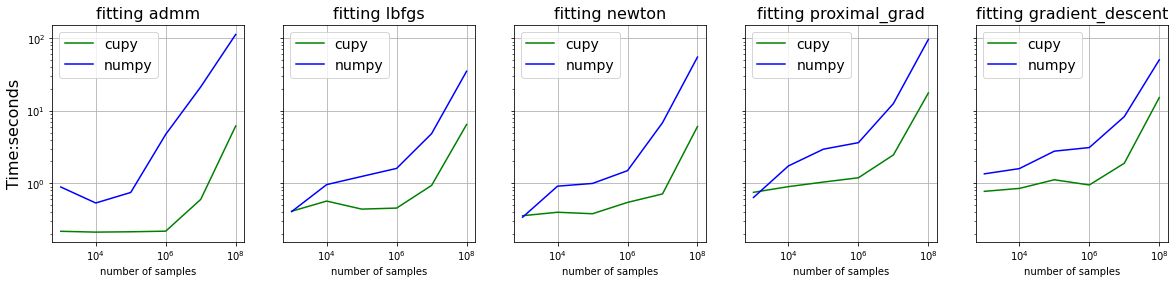

In [15]:
fig, axs = plt.subplots(1,5, figsize=(20, 4),sharex=True,sharey=True)
solvers = ['admm', 'lbfgs', 'newton', 'proximal_grad', 'gradient_descent']
nsamples = [10**i for i in range(3,9)]
axs[0].set_ylabel("Time:seconds",fontsize=16)
for c,s in enumerate(solvers):
    axs[c].plot(nsamples,cupy_time[s],color='g',label='cupy')
    axs[c].plot(nsamples,numpy_time[s],color='b',label='numpy')
    axs[c].set_xscale("log")
    axs[c].set_yscale("log")
    axs[c].grid()
    axs[c].set_title('fitting %s'%(s),fontsize=16)
    axs[c].set_xlabel("number of samples",)
    axs[c].legend(fontsize=14)
plt.savefig("dask_glm_cupy_vs_numpy.pdf",format='pdf',quality=95)

In [16]:
print(cupy_time)

{'admm': [0.21765828132629395, 0.21206355094909668, 0.21434640884399414, 0.218580961227417, 0.5990934371948242, 6.163001775741577], 'lbfgs': [0.4115731716156006, 0.5681309700012207, 0.4402155876159668, 0.4547250270843506, 0.9348490238189697, 6.4634690284729], 'newton': [0.35703039169311523, 0.398423433303833, 0.38001060485839844, 0.544623851776123, 0.7127010822296143, 6.064377069473267], 'proximal_grad': [0.7502241134643555, 0.898841142654419, 1.0394632816314697, 1.19075345993042, 2.4594533443450928, 17.606927156448364], 'gradient_descent': [0.7738261222839355, 0.8494710922241211, 1.118093490600586, 0.9474565982818604, 1.8884577751159668, 15.209191083908081]}


In [17]:
print(numpy_time)

{'admm': [0.8883583545684814, 0.5346331596374512, 0.7470958232879639, 4.729389667510986, 21.334040641784668, 112.82100319862366], 'lbfgs': [0.4072704315185547, 0.9585769176483154, 1.2415602207183838, 1.6037938594818115, 4.840105295181274, 35.08968257904053], 'newton': [0.34020328521728516, 0.9122247695922852, 0.9947090148925781, 1.493607759475708, 6.841528654098511, 55.02232217788696], 'proximal_grad': [0.6367027759552002, 1.7351338863372803, 2.953031539916992, 3.631437063217163, 12.565171241760254, 96.42689514160156], 'gradient_descent': [1.3490593433380127, 1.5929501056671143, 2.7714388370513916, 3.1076557636260986, 8.304282188415527, 50.385417222976685]}
